<a href="https://colab.research.google.com/github/FLjv77/Quantum_ML_Course/blob/main/codes/ErrorCorrection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Installation

In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 66.0 MB/s eta 0:00:00


###Imports

In [43]:
import pennylane as qml
from pennylane import numpy as np

###Const Values

In [70]:
ideal = np.array([np.cos(np.pi/8), np.sin(np.pi/8)])


###Utilites

In [71]:
def getFidelity(state1, state2):
  return np.dot(state1, state2) ** 2

###Noise

In [74]:
def error_type1(num, p):
  for i in range(num):
    if np.random.rand() < p:
      qml.X(wires = [i])
  return qml.state

def error_type2(num, p):
  for i in range(num):
    if np.random.rand() < p:
      qml.Y(wires = [i])
  return qml.state

def error_type3(p):
  for i in range(9):
    if(np.random.rand() < p):
      dis = np.random.randint(0, 9) % 3
      if dis == 0:
        qml.PauliX(wires=i)
      elif dis == 1:
        qml.PauliY(wires=i)
      elif dis == 2:
        qml.PauliY(wires=i)

  return qml.state

###Circuits

####A Bit Error

In [80]:
dev = qml.device("default.mixed", wires=3)
@qml.qnode(dev)
def bitflip_code(p, num):
  #Init state
  qml.RY(np.pi/4, wires=0)

  #Encode
  qml.CNOT(wires = [0, 1])
  qml.CNOT(wires = [0, 2])

  #Noise
  error_type1(num, p)

  #Decode
  qml.CNOT(wires = [0, 1])
  qml.CNOT(wires = [0, 2])
  qml.Toffoli(wires = [1, 2, 0])

  return qml.probs(wires=0)

@qml.qnode(dev)
def phaseflip_code(p, num):
  #Init state
  qml.RY(np.pi/4, wires=0)

  #Encode
  qml.CNOT(wires = [0, 1])
  qml.CNOT(wires = [0, 2])
  for i in [0, 1, 2]:
    qml.H(i)

  #Noise
  error_type2(num, p)

  #Decode
  for i in [0, 1, 2]:
    qml.H(i)

  qml.CNOT(wires = [0, 1])
  qml.CNOT(wires = [0, 2])
  qml.Toffoli(wires = [1, 2, 0])

  return qml.probs(wires=0)

Fidelity: 1.0
(<Figure size 1000x400 with 1 Axes>, <Axes: >)


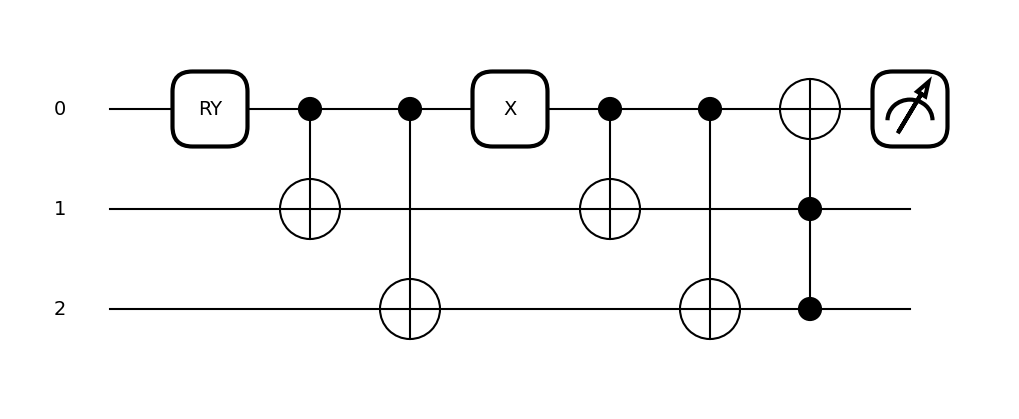

In [86]:
p = 0.99
num = 1
result = bitflip_code(p, num)
fidelity = getFidelity(np.sqrt(result), (ideal))
print("Fidelity:", fidelity)
print(qml.draw_mpl(bitflip_code)(p, num))

####Multi Bit Error

In [37]:
dev = qml.device("default.qubit", wires=9)

@qml.qnode(dev)
def shor_code(p):
    # Step 1: Initialize logical qubit |ψ⟩ = cos(π/8)|0⟩ + sin(π/8)|1⟩ on wire 0
    qml.RY(np.pi/4, wires=0)

    # Step 2: Phase-flip code — spread to wires 0,1,2
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[0, 6])

    # Step 3: Bit-flip encoding of each of the above three qubits
    for i in [0, 1, 2]:
        t = i * 3
        qml.Hadamard(wires=t)
        qml.CNOT(wires=[t, t+1])
        qml.CNOT(wires=[t, t+2])

    # ----- ERROR OCCURS HERE -----
    # Simulate error: try different options like X, Y, Z on one wire
    error_type3(p)

    # Step 4: Decode (inverse of bit-flip and phase-flip encoding)
    for i in [0, 1, 2]:
        t = i * 3
        qml.CNOT(wires=[t, t+1])
        qml.CNOT(wires=[t, t+2])
        qml.Toffoli(wires=[t+1, t+2, t])
        qml.Hadamard(wires=t)


    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[0, 6])
    qml.Toffoli(wires=[6, 3, 0])

    return qml.probs(wires=0)


(<Figure size 1700x1000 with 1 Axes>, <Axes: >)


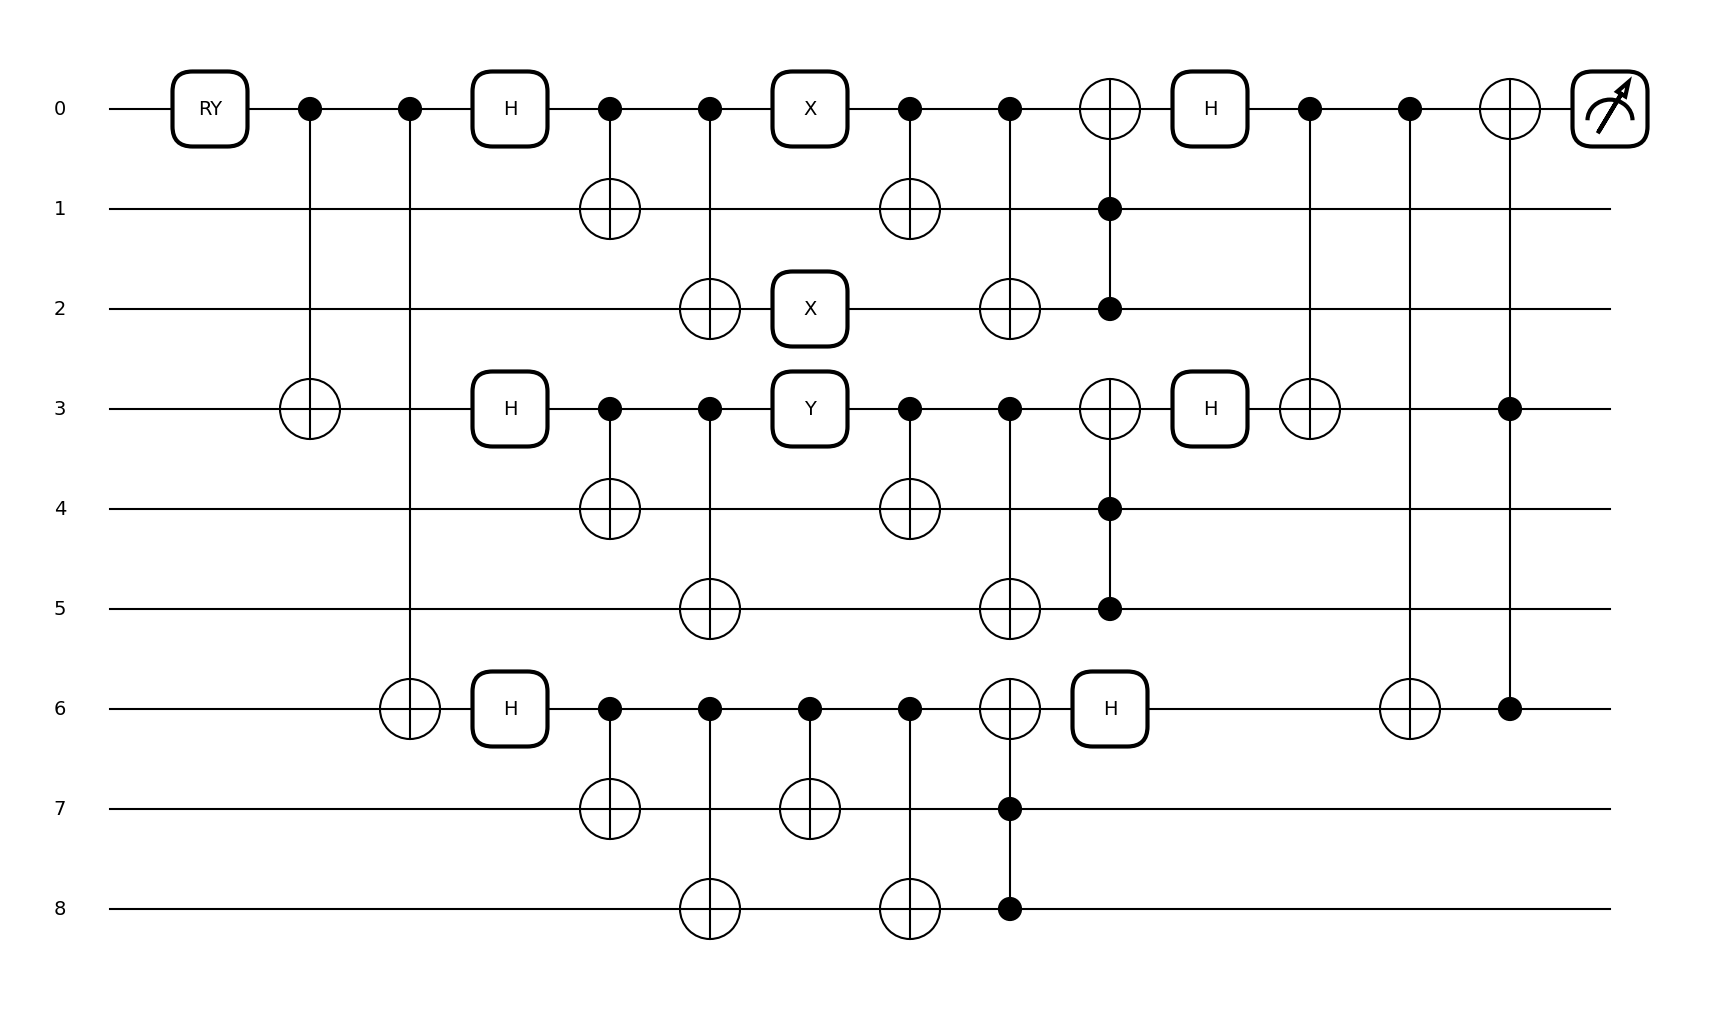

In [38]:
print(qml.draw_mpl(shor_code)(0.3))

In [41]:
ideal = np.array([np.cos(np.pi/8), np.sin(np.pi/8)])
result = shor_code(0.9)
fidelity = np.dot(np.sqrt(result), (ideal)) ** 2
print("Fidelity:", fidelity)

Fidelity: 0.9999999999999991
